In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# calculate expression correlation for all pair
df = pd.read_csv("../../data/perturb/clustered_mean_gene_expression_figs2-4.csv", sep=",", low_memory=False, index_col=0)
df = df.iloc[2:, 1:].T.fillna(0)
corr_df = df.corr()
# convert df to long format
corr_df_long = pd.DataFrame(corr_df.values.reshape(-1))
corr_df_long[1] = np.repeat(list(df.columns), 2319)
corr_df_long[2] = list(df.columns)*2319
corr_df_long = corr_df_long[corr_df_long[1] != corr_df_long[2]].copy()
corr_df_long[3] = corr_df_long[1]+"_"+corr_df_long[2]
del corr_df_long[1]
del corr_df_long[2]
corr_df_long[4] = "All"

In [3]:
# dagma network in gene name
dagma = pd.read_csv("../../result/network/DAGMA_DAG.tsv", sep="\t", header=None)
genes = pd.read_csv("../../result/data/genes_gene_perturb", header=None)[0].to_dict()
dagma[0] = dagma[0].map(genes)
dagma[1] = dagma[1].map(genes)
# all pairs in dagma network, convert to both direction
dagma_pair = np.concatenate([(dagma[0]+"_"+dagma[1]).values, (dagma[1]+"_"+dagma[0]).values])
corr_df_long.loc[corr_df_long[3].isin(dagma_pair), 4] = "LatentDAG"

In [4]:
# all possible pairs between dagma network genes, include both direction
dagma_all_pair = list(itertools.permutations(set.union(set(dagma[0]), set(dagma[1])), 2))
dagma_all_pair = [ii[0]+"_"+ii[1] for ii in dagma_all_pair]
# remove those exist in dagma network
dagma_possible_pair = set(dagma_all_pair) - set(dagma_pair)
corr_df_long.loc[corr_df_long[3].isin(dagma_possible_pair), 4] = "LatentDAG_possible"

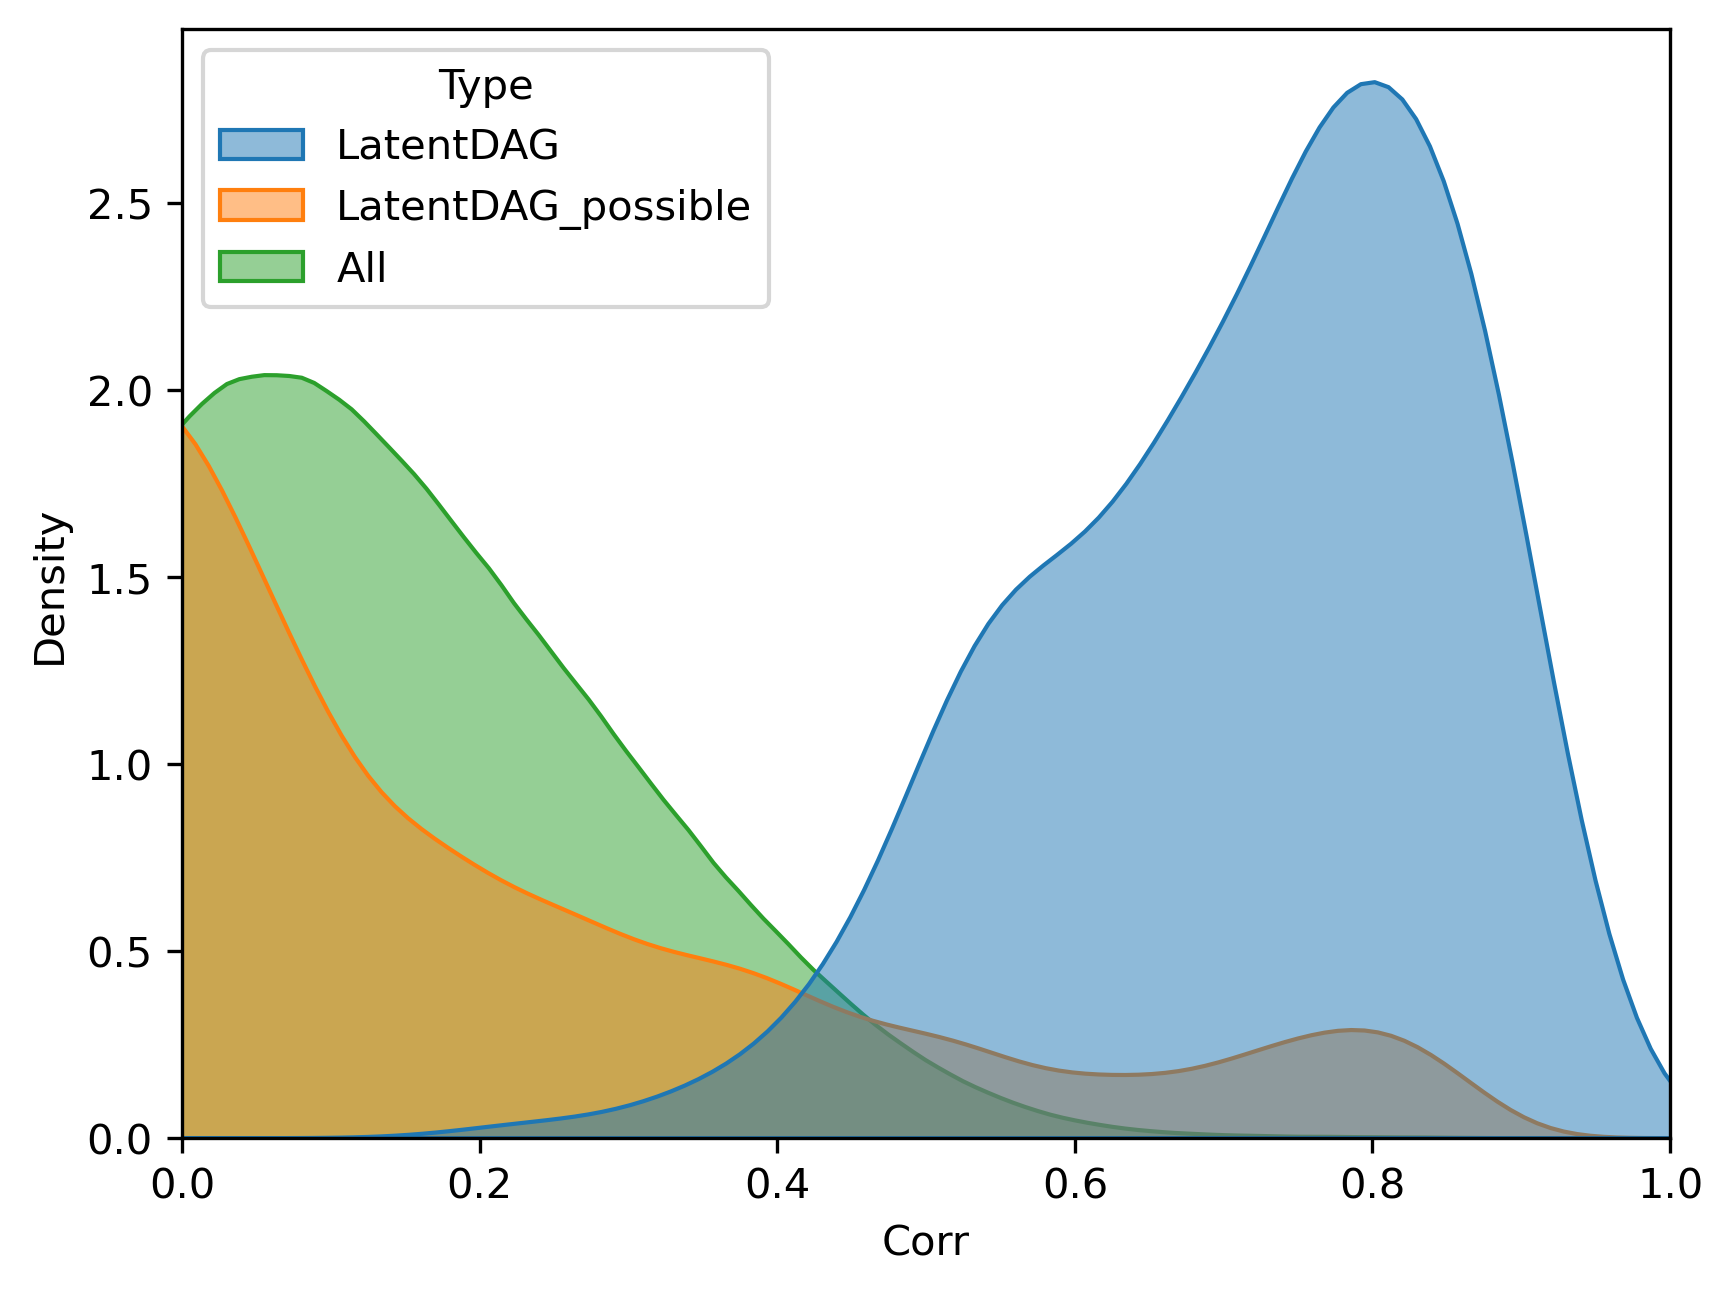

In [6]:
corr_df_long.columns = ["Corr", "Pair", "Type"]
corr_df_long = corr_df_long.sort_values("Type", key=lambda x: x.map({"LatentDAG":0, "LatentDAG_possible":1, "All":2}))

plt.figure(dpi=300)
ax = sns.kdeplot(data = corr_df_long, x='Corr', hue='Type', fill=True, common_norm=False, alpha=0.5)
sns.move_legend(ax, "upper left")
plt.xlim([0, 1])
plt.savefig("dagma_vs_corr.pdf", dpi=300, bbox_inches='tight')

In [8]:
corr_df_long.to_csv("dagma_vs_corr.txt", sep="\t", index=False)